# This noteBook is for Preprocessing the External Image Dataset


# Importing packages

In [2]:
import pandas as pd
import numpy as np

import cv2
import matplotlib.pylab as plt

from glob import glob as glob

# Reading images from the dataset

In [ ]:
crack_img = glob("../data/external/Crack/*.jpg")
noncrack_img = glob("../data/external/Non-crack/*.jpg")


img_cv2 = plt.imread(crack_img[12])

['../data/external/Crack\\00001.jpg', '../data/external/Crack\\00002.jpg', '../data/external/Crack\\00003.jpg', '../data/external/Crack\\00004.jpg', '../data/external/Crack\\00005.jpg', '../data/external/Crack\\00006.jpg', '../data/external/Crack\\00007.jpg', '../data/external/Crack\\00008.jpg', '../data/external/Crack\\00009.jpg', '../data/external/Crack\\00010.jpg', '../data/external/Crack\\00011.jpg', '../data/external/Crack\\00012.jpg', '../data/external/Crack\\00013.jpg', '../data/external/Crack\\00014.jpg', '../data/external/Crack\\00015.jpg', '../data/external/Crack\\00016.jpg', '../data/external/Crack\\00017.jpg', '../data/external/Crack\\00018.jpg', '../data/external/Crack\\00019.jpg', '../data/external/Crack\\00020.jpg', '../data/external/Crack\\00021.jpg', '../data/external/Crack\\00022.jpg', '../data/external/Crack\\00023.jpg', '../data/external/Crack\\00024.jpg', '../data/external/Crack\\00025.jpg', '../data/external/Crack\\00026.jpg', '../data/external/Crack\\00027.jpg', 

# Displaying Crack images in RGB

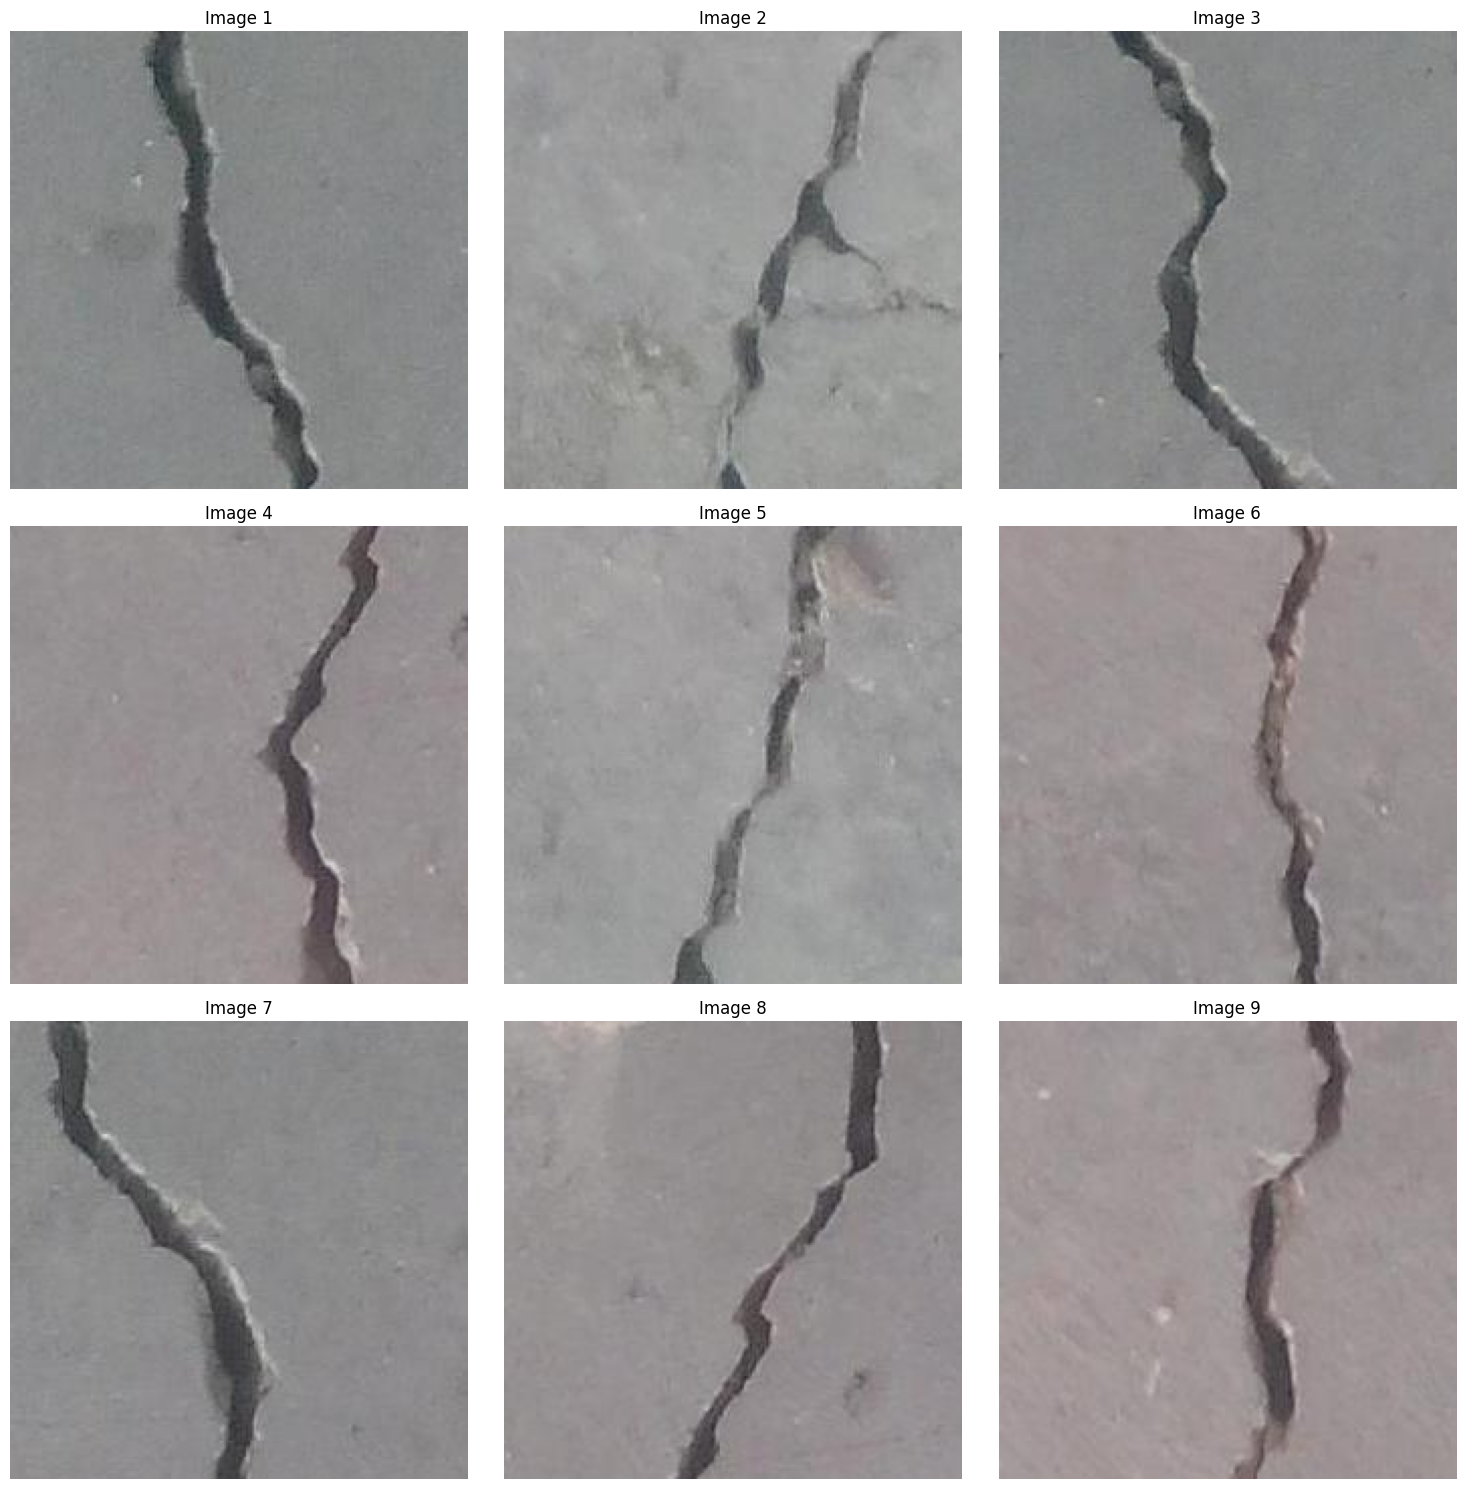

In [4]:
num_images = len(crack_img)


cols = 3  
rows = 3
total = rows*cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows) )

# Flatten axes array in case of multiple rows
axes = axes.flatten()

# Loop through images and plot them
for i, img_path in enumerate(crack_img):
    if(i<(total)):
        img = cv2.imread(img_path)  # Read the image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        axes[i].imshow(img)  # Display image
        axes[i].set_title(f"Image {i+1}")
        axes[i].axis("off")

# # Hide any unused subplots
# for j in range(i + 1, len(axes)):
#     axes[j].axis("off")

plt.tight_layout()
plt.show()


# Displaying the image

(np.float64(-0.5), np.float64(226.5), np.float64(226.5), np.float64(-0.5))

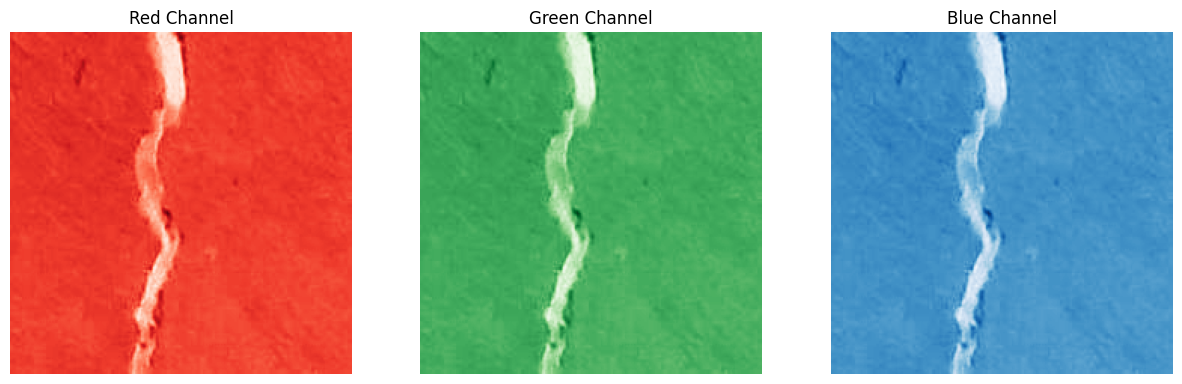

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].imshow(img_cv2[:, :, 0], cmap='Reds')
axes[0].set_title("Red Channel")
axes[0].axis('off')


axes[1].imshow(img_cv2[:, :, 0], cmap='Greens')
axes[1].set_title("Green Channel")
axes[1].axis('off')


axes[2].imshow(img_cv2[:, :, 0], cmap='Blues')
axes[2].set_title("Blue Channel")
axes[2].axis('off')

# Dilatting the Image Using Adaptive Canny

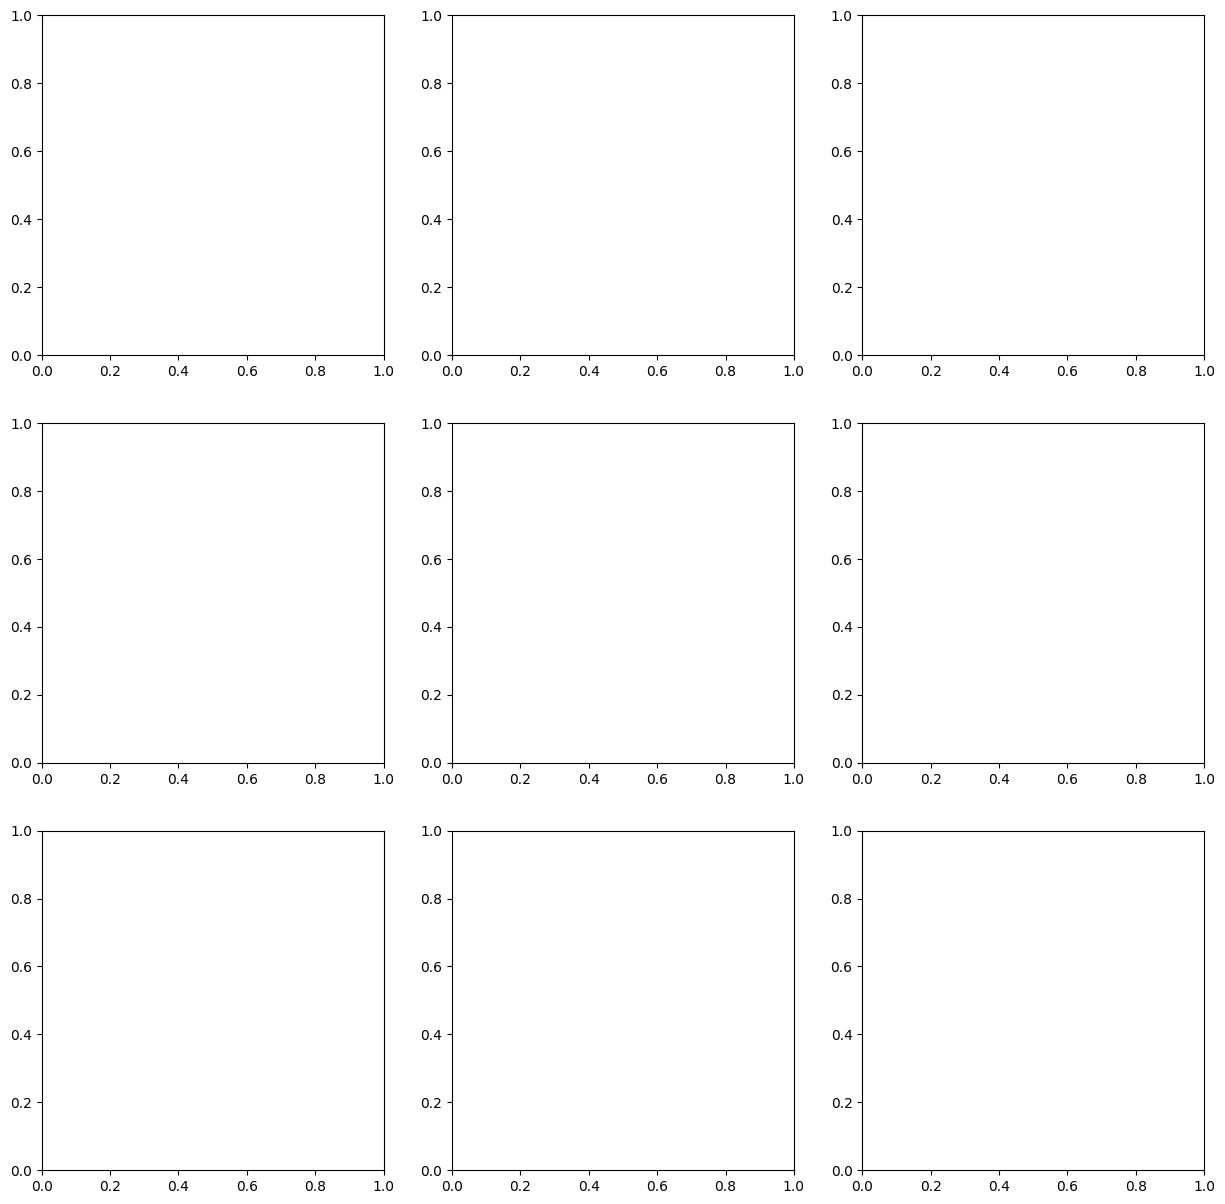

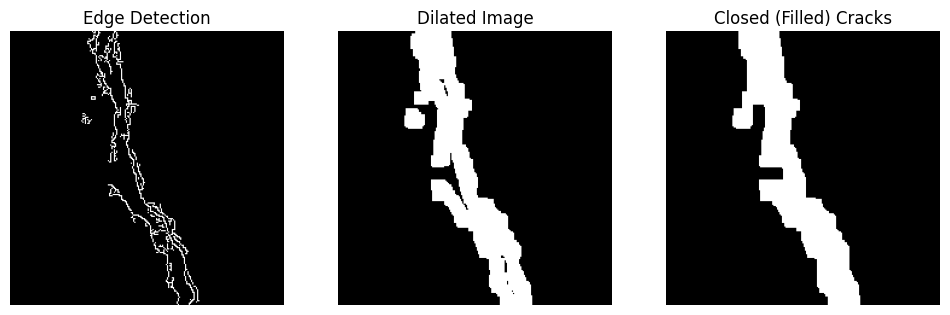

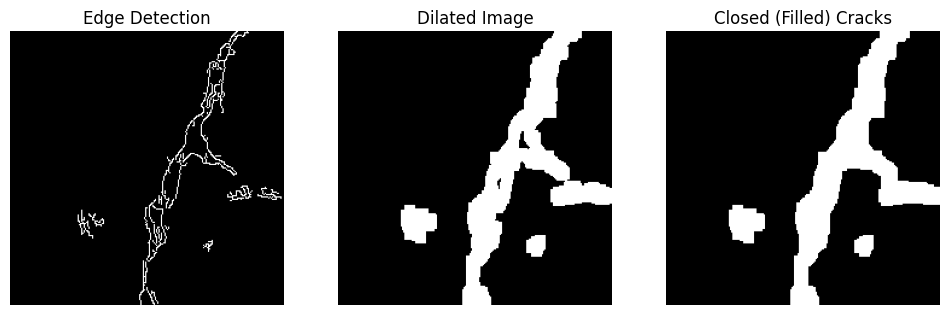

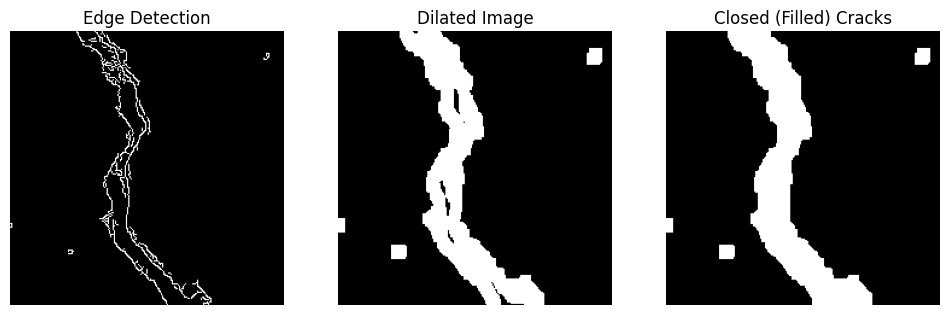

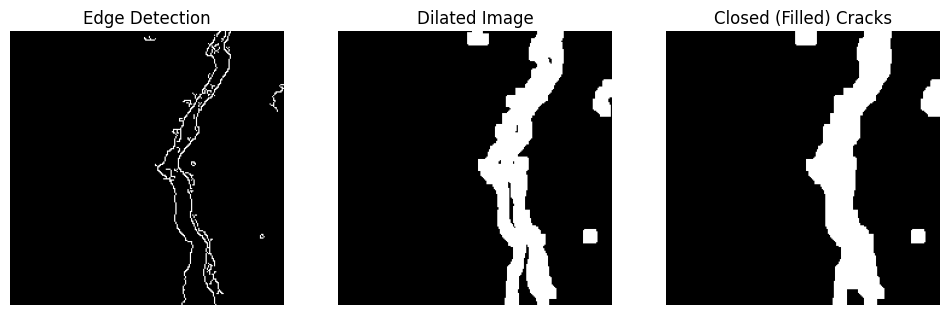

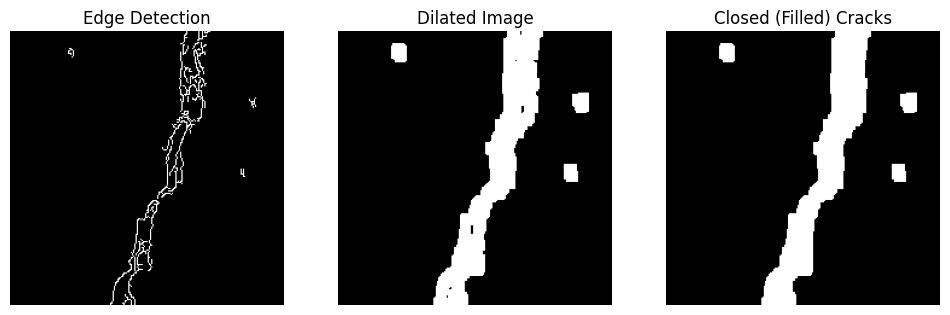

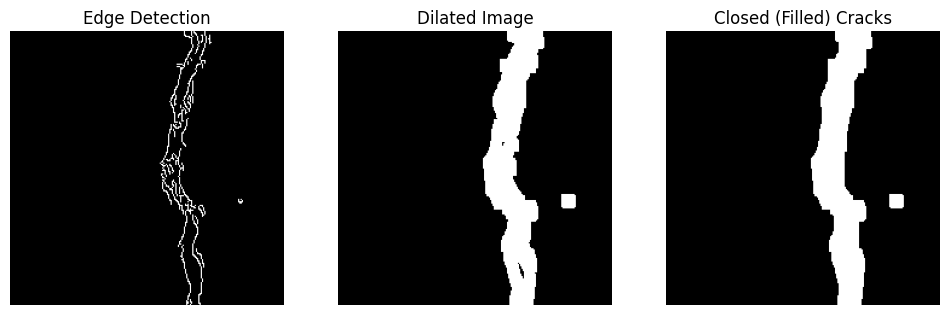

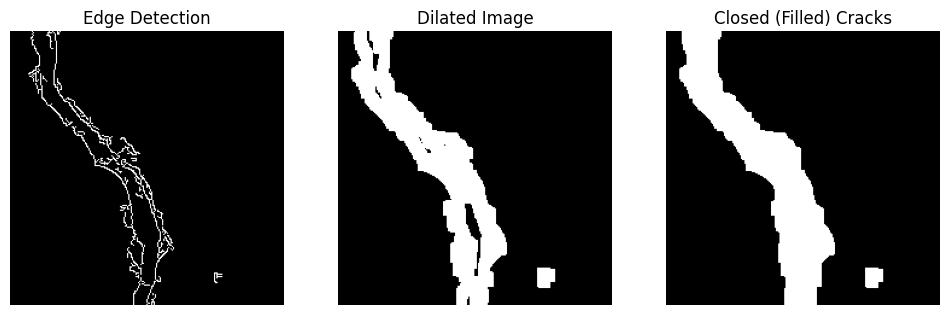

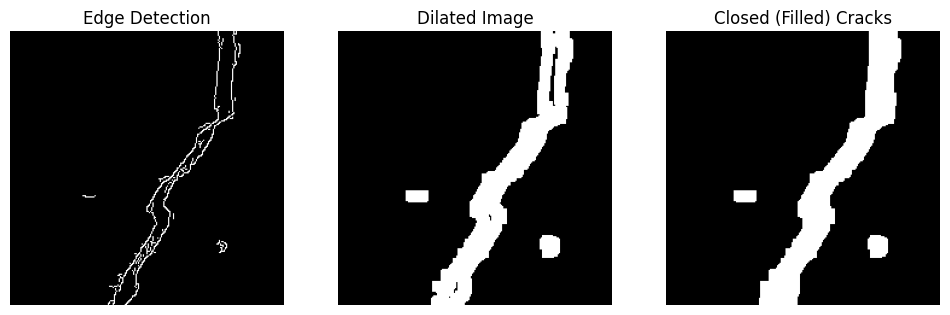

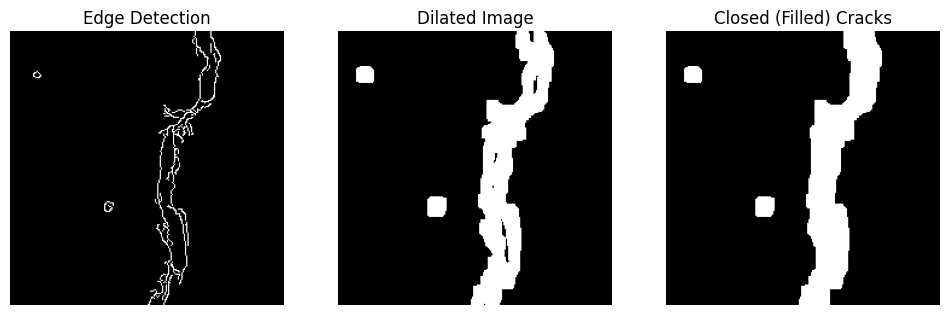

<Figure size 640x480 with 0 Axes>

In [19]:
fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows) )

# Flatten axes array in case of multiple rows
axes = axes.flatten()

# Loop through images and plot them
for i, img_path in enumerate(crack_img):
    if(i<(total)):
        # img = cv2.imread(img_path)  # Read the image
        # img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert from BGR to RGB
        
        # Load the image
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Apply edge detection
        edges = cv2.Canny(image, 50, 150)

        # Dilation to enhance connectivity
        kernel = np.ones((5, 5), np.uint8)

        # Apply Dilation to thicken the cracks
        dilated = cv2.dilate(edges, kernel, iterations=2)

        # Apply Morphological Closing to fill gaps
        closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel, iterations=2)

        # Visualize the result
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(edges, cmap="gray")
        plt.title("Edge Detection")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(dilated, cmap="gray")
        plt.title("Dilated Image")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(closed, cmap="gray")
        plt.title("Closed (Filled) Cracks")
        plt.axis("off")

        plt.show()
# # Hide any unused subplots
# for j in range(i + 1, len(axes)):
#     axes[j].axis("off")

plt.tight_layout()
plt.show()

# Convert to binary matrix

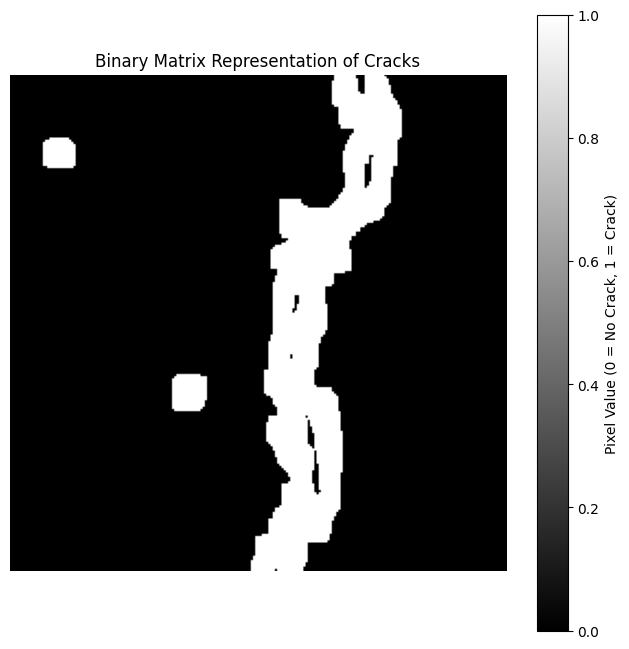

In [20]:
binary_matrix = (dilated > 0).astype(int)

plt.figure(figsize=(8, 8))
plt.imshow(binary_matrix, cmap="gray")  # Use 'gray' colormap for better contrast
plt.colorbar(label="Pixel Value (0 = No Crack, 1 = Crack)")
plt.title("Binary Matrix Representation of Cracks")
plt.axis("off")  # Hide axis for better visualization
plt.show()

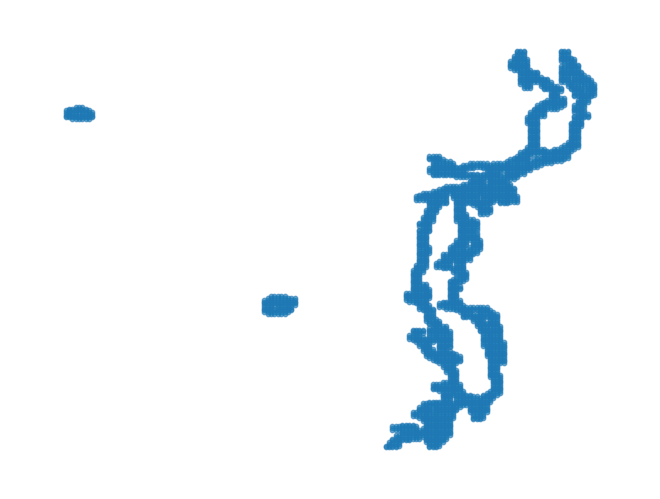

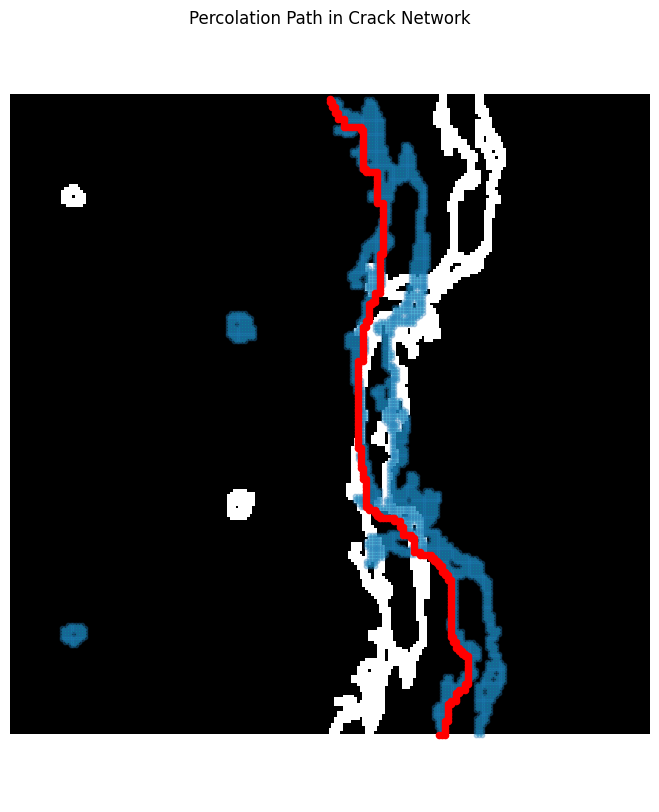

In [18]:
import networkx as nx

def create_graph(binary_matrix):
    rows, cols = binary_matrix.shape
    G = nx.Graph()

    for i in range(rows):
        for j in range(cols):
            if binary_matrix[i, j] == 1:
                G.add_node((i, j))

                # Connect to neighboring pixels (4 or 8 connectivity)
                for di, dj in [(0, 1), (1, 0), (0, -1), (-1, 0)]:  # 4-connectivity
                    ni, nj = i + di, j + dj
                    if 0 <= ni < rows and 0 <= nj < cols and binary_matrix[ni, nj] == 1:
                        G.add_edge((i, j), (ni, nj))

    return G

# Create the crack graph
G = create_graph(binary_matrix)

# Check if there is a path between the first and last row
top_nodes = [(0, j) for j in range(binary_matrix.shape[1]) if binary_matrix[0, j] == 1]
bottom_nodes = [(binary_matrix.shape[0] - 1, j) for j in range(binary_matrix.shape[1]) if binary_matrix[-1, j] == 1]

percolates = any(nx.has_path(G, top, bottom) for top in top_nodes for bottom in bottom_nodes)

# Find a percolation path if it exists
percolation_path = None
for top in top_nodes:
    for bottom in bottom_nodes:
        if nx.has_path(G, top, bottom):
            percolation_path = nx.shortest_path(G, source=top, target=bottom)
            break
    if percolation_path:
        break

# Draw the graph on top of the crack image
pos = {node: (node[1], binary_matrix.shape[0] - node[0]) for node in G.nodes()}  # Flip y-axis
nx.draw(G, pos, node_size=10, edge_color="cyan", alpha=0.6, with_labels=False)

# Plot the binary image again
plt.figure(figsize=(10, 10))
plt.imshow(binary_matrix, cmap="gray", interpolation="nearest")
plt.title("Percolation Path in Crack Network")

# Draw the full graph
nx.draw(G, pos, node_size=10, edge_color="cyan", alpha=0.3, with_labels=False)

# Highlight the percolation path in red
if percolation_path:
    nx.draw_networkx_nodes(G, pos, nodelist=percolation_path, node_color="red", node_size=20)
    nx.draw_networkx_edges(G, pos, edgelist=list(zip(percolation_path[:-1], percolation_path[1:])), edge_color="red", width=2)

plt.show()
